In [1]:
using DataFrames, CSV, UniversalDiffEq

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
using Pkg
Pkg.status("UniversalDiffEq")

Status `~/.julia/environments/v1.10/Project.toml`
  [791b002b] UniversalDiffEq v1.1.1 `https://github.com/Jack-H-Buckner/UniversalDiffEq.jl.git#main`


In [3]:
UniversalDiffEq.kalman_filter!

kalman_filter! (generic function with 2 methods)

# Kelp forest NODE model

This is a reletivly simple model for kelp forest dynamics that accounts for differnce between sites. It describes changes in the log abundance of juvile kelp (less than one meter) $u_{J,i}$ and adult kelp $u_{A,i}$ in each sites (index by $i$) as a function of their current log  abundances, the log abundnace of pycnopodia sea starts $X_{p,i}(t)$ and locaiton effects $X_i$. We assume no prior knowedge of these relationships and use a nerual network to learn the relevant funtional forms

$$
\frac{du_{J,i}}{dt} = NN_J(u_{J,i},u_{A,t}, X_{p,i}(t), X_i) \\
\frac{du_{A,i}}{dt} = NN_A(u_{J,i},u_{A,t}, X_{p,i}(t), X_i)
$$

I have chosen to model the effect of pycnopodial on kelp abundance rather than a sea urchin abundnace because the effects of these grazers on kelp often has more to do with urchin behavior than their numerical abundance. The behavioral respnce of these herbivors tend to be determined by the avaiabiltiy of food (i.e. the abundace of kelp) and predators like pycnopodia. 

The effects of location on the population dynamics are captured by a covarite $X_i$ that varies by site by not over time. In the simples case I ignore $X_i$ and assume the dynamcis are identical between sites. In the second case I assume there are unobserved site level factors that influence the dynamics which I model by passing an indicator varaible to the neural network and the final case assumes differnce in dynamics betwen location can be explained by the roughness of the sea floor at each location.  


In [4]:
dat = CSV.read("../data/processed_time_series.csv", DataFrame)[:,2:end]
rename!(dat, ["time","series","juv","adult"])
training = dat[dat.time .< 55,:]
testing = dat[dat.time .>= 55,:]

X = CSV.read("../data/processed_rugosity.csv", DataFrame)[:,[2,3,6,7]]
rename!(X, ["time","series", "pycnopodia",  "rugosity"])
dat[1:4,:]

4×4 DataFrame
 Row │ time   series  juv         adult     
     │ Int64  Int64   Float64     Float64   
─────┼──────────────────────────────────────
   1 │     1       1  -1.0498     -0.197155
   2 │     1       2  -0.0421156  -0.394327
   3 │     1       3   0.377395    0.211176
   4 │     1       4  -1.28535    -0.113676

In [5]:
Vars = CSV.read("../data/kelp_obs_errors.csv", DataFrame)[:,2:end]
Σ_kelp = [Vars.sigma2[1] 0 ; 0 Vars.sigma2[2]]
Σ_kelp

2×2 Matrix{Float64}:
 0.0898678  0.0
 0.0        0.109365

In [6]:
X[1:4,:]

4×4 DataFrame
 Row │ time   series  pycnopodia  rugosity 
     │ Int64  Int64   Float64     Float64  
─────┼─────────────────────────────────────
   1 │     1       1   -0.532124  -0.87251
   2 │     1      23   -0.532124  -0.87251
   3 │     1      37   -0.532124  -0.87251
   4 │     1      47   -0.532124  -0.87251

# Model Fixed between sites

In this simplest case I assume the dynamcis are identical between sites. 

$$
\frac{du_{J,i}}{dt} = NN_J(u_{J,i},u_{A,t}, X_{p,i}(t)) \\
\frac{du_{A,i}}{dt} = NN_A(u_{J,i},u_{A,t}, X_{p,i}(t))
$$

In [9]:
NN, NNparameters = SimpleNeuralNetwork(2+1,2, hidden = 5)

function derivs_1!(du,u,i,X,p,t)
    du .=  NN(vcat(u,X[1:1]), p.NN) # index 3 is pycnopodia 
end

init_parameters = (NN = NNparameters, )

model_1 = MultiCustomDerivatives(training,X,derivs_1!,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")

model_1.loss_function(model_1.parameters)


2.2944968075736307

In [10]:
gradient_descent!(model_1, verbose = true, maxiter = 100, step_size = 0.05)

2.294 2.091 1.933 1.793 1.66 1.534 1.415 1.306 1.206 1.114 1.03 0.953 0.883 0.819 0.759 0.705 0.655 0.61 0.569 0.532 0.499 0.469 0.443 0.418 0.396 0.376 0.358 0.342 0.328 0.315 0.303 0.292 0.282 0.274 0.266 0.258 0.252 0.246 0.24 0.235 0.231 0.227 0.223 0.22 0.216 0.214 0.211 0.209 0.207 0.205 0.203 0.202 0.201 0.199 0.198 0.197 0.197 0.196 0.195 0.195 0.194 0.194 0.193 0.193 0.192 0.192 0.192 0.191 0.191 0.191 0.19 0.19 0.19 0.19 0.189 0.189 0.189 0.189 0.188 0.188 0.188 0.187 0.187 0.187 0.187 0.186 0.186 0.186 0.186 0.185 0.185 0.185 0.185 0.184 0.184 0.184 0.183 0.183 0.183 0.182 0.182 

In [ ]:
Pν, Px = UniversalDiffEq.kalman_filter!(model_1, Σ_kelp, verbose = true, maxiter = 100, step_size = 0.05)
Pν, Px= UniversalDiffEq.kalman_filter!(model_1, Σ_kelp; Pν = Pν, verbose = true, maxiter = 250, step_size = 0.01)

3222.381 1618.218 1454.525 1210.33 1044.123 942.715 885.34 859.478 851.346 845.468 833.303 816.855 802.299 793.277 789.297 788.372 788.106 786.964 784.397 780.504 775.725 770.63 765.745 761.428 757.827 755.032 752.507 750.433 748.484 746.503 744.399 742.168 739.886 737.671 735.649 733.905 732.463 731.284 730.287 729.38 728.488 727.574 726.637 725.701 724.803 723.976 723.242 722.611 722.079 721.629 721.239 720.879 720.519 720.138 719.719 719.26 718.77 718.267 717.771 717.296 716.849 716.424 716.018 715.616 715.213 714.808 714.409 714.018 713.642 713.277 712.919 712.567 712.215 711.865 711.517 711.171 710.826 710.483 710.143 709.807 709.474 709.143 708.812 708.479 708.143 707.805 707.468 707.132 706.799 706.469 706.14 705.814 705.488 705.165 704.841 704.521 704.2 703.88 703.566 703.249 703.249 

([0.9302102807543072 0.0; 0.0 0.7177457986417932], [1.0115631184803826 0.007248087814791027; 0.007248087814791138 0.8076989248880381;;; 1.007986251176991 0.010523549957787703; 0.010523549957832556 0.8019086098354409;;; 1.0006665447462 0.013044851143001301; 0.013044851143001246 0.7933900473576796;;; … ;;; 1.0134246821928743 -0.0014076619046934358; -0.0014076619046694688 0.7878818928626937;;; 1.0141118620891532 -0.00038001429428552794; -0.00038001429426453084 0.7890535991511003;;; 1.012740961227085 0.005014985241882208; 0.005014985241877767 0.797905170379769])

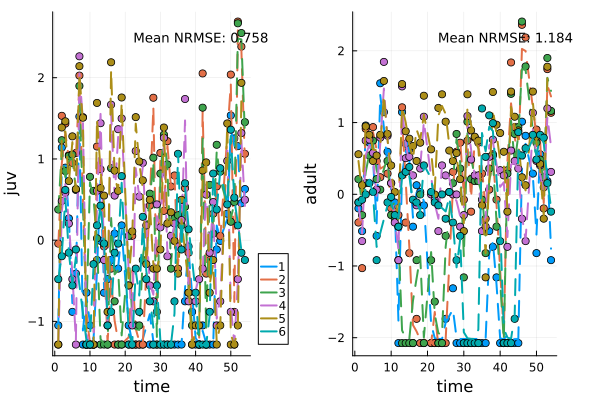

In [38]:
plot_state_estimates(model_1)

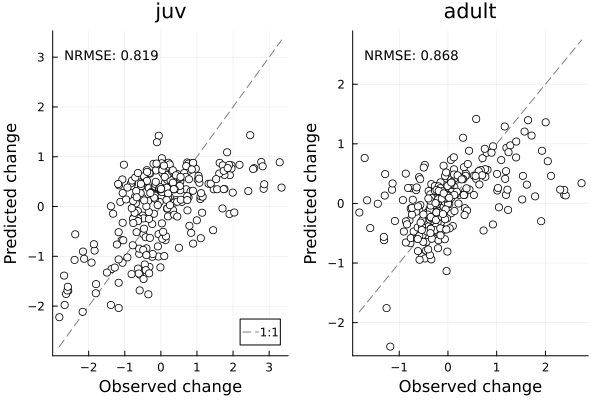

In [39]:
plot_predictions(model_1)

In [ ]:
# simulated the predicted dynamics 

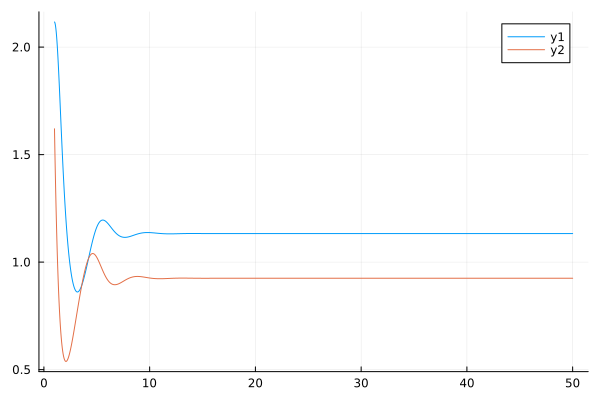

In [43]:
using Distributions, Plots

site = 3
with_noise = false
sigma = 1.0

rhs = u -> model_1.process_model.right_hand_side(u,site,[0,0,1.0],model_1.parameters.process_model,0)
u = [0.5,0.75]
dt_ = 0.01
kelp = []
j_kelp = []

for i in 1:dt_:50
    u = u .+ dt_*rhs(u)
    if with_noise 
        u =  u .+ dt_ .* [sigma,0] .* (rand(Normal(0,1),2)) 
    end 
    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(1:dt_:50,exp.(kelp))
Plots.plot!(1:dt_:50,exp.(j_kelp))

# Model with site level indicators

I include site level indicator variables with a one-hot encoding which is a vector of zeros accept for one entry hat takes the value of one representing the site under consideration.  for example if there were four sites and we wanted to ake a prediciton for the third the one-hot encoding vector would be 

$$
X_3 = \{0,0,1,0\}
$$


In [72]:
NN, NNparameters = SimpleNeuralNetwork(2+7,2,hidden = 5)

function derivs_2!(du,u,i,X,p,t)
    index = round(Int,i)
    one_hot = zeros(6)
    one_hot[index] = 1
    inputs = vcat(vcat(u,X[1:1]),one_hot)
    du .=  NN(inputs ,p.NN)
end

init_parameters = (NN = NNparameters, )

model_2 = MultiCustomDerivatives(dat,X,derivs_2!,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")
nothing

In [73]:
gradient_descent!(model_2, verbose = true, maxiter = 100, step_size = 0.05)

2.196 1.952 1.769 1.609 1.469 1.347 1.242 1.147 1.062 0.982 0.909 0.841 0.779 0.723 0.672 0.625 0.583 0.544 0.509 0.477 0.449 0.423 0.4 0.379 0.36 0.343 0.328 0.314 0.302 0.29 0.28 0.27 0.262 0.254 0.247 0.241 0.236 0.23 0.226 0.221 0.217 0.214 0.211 0.208 0.205 0.203 0.201 0.199 0.197 0.196 0.195 0.193 0.192 0.191 0.191 0.19 0.189 0.189 0.188 0.188 0.187 0.187 0.187 0.186 0.186 0.186 0.186 0.185 0.185 0.185 0.185 0.185 0.185 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.182 0.182 0.182 0.182 0.182 0.182 0.182 0.182 0.182 0.181 0.181 0.181 0.181 0.181 

In [78]:
Pν, Px = UniversalDiffEq.kalman_filter!(model_2, Σ_kelp, verbose = true, maxiter = 100, step_size = 0.01)

3454.79 3137.407 2895.374 2585.85 2468.343 2431.908 2412.327 2378.281 2324.105 2255.65 2180.588 2104.934 2032.413 1964.803 1902.518 1845.144 1791.857 1741.777 1694.197 1648.663 1604.993 1563.201 1523.349 1485.572 1449.953 1416.536 1385.32 1356.263 1329.279 1304.277 1281.161 1259.86 1240.285 1222.364 1206.019 1191.161 1177.689 1165.491 1154.44 1144.405 1135.258 1126.873 1119.136 1111.949 1105.229 1098.907 1092.932 1087.26 1081.864 1076.719 1071.81 1067.122 1062.645 1058.367 1054.281 1050.375 1046.642 1043.073 1039.659 1036.393 1033.268 1030.277 1027.414 1024.676 1022.056 1019.548 1017.15 1014.856 1012.66 1010.564 1008.54 1006.612 1004.76 1002.98 1001.269 999.623 998.036 996.506 995.03 993.605 992.226 990.894 989.697 988.358 987.149 985.977 984.841 983.739 982.67 981.63 980.62 979.638 978.681 977.755 976.835 975.954 975.104 974.253 973.429 972.623 972.623 

([0.5204767945678188 0.0; 0.0 0.716010061954723], [0.5993540074612096 0.009798044490983981; 0.009798044491369673 0.8047924103914398;;; 0.5980552414889481 0.007225286086034843; 0.007225286086034899 0.7999872463801219;;; 0.600026819356556 0.006150136331743883; 0.006150136331743938 0.7992214139304519;;; … ;;; 0.5988313386748352 0.00919408854325765; 0.009194088543257595 0.7970532316329586;;; 0.5996365179416643 0.00980302503901831; 0.009803025039175628 0.7899588092242121;;; 0.5983146813486993 0.009339494617063737; 0.009339494617063349 0.7993784642078647])

In [84]:
Pν, Px= UniversalDiffEq.kalman_filter!(model_2, Σ_kelp; Pν = Pν, verbose = true, maxiter = 100, step_size = 0.0025)

972.623 971.066 969.546 968.059 966.602 965.174 963.774 962.401 961.056 959.738 958.444 957.174 955.928 954.704 953.503 952.324 951.165 950.026 948.906 947.803 946.717 945.647 944.592 943.552 942.524 941.51 940.507 939.515 938.534 937.563 936.601 935.648 934.702 933.765 932.834 931.91 930.993 930.082 929.176 928.277 927.384 926.496 925.614 924.737 923.867 923.003 922.143 921.292 920.447 919.609 918.779 917.955 917.14 916.334 915.536 914.746 913.966 913.195 912.433 911.68 910.936 910.202 909.478 908.763 908.058 907.366 906.678 906.002 905.337 904.682 904.037 903.401 902.775 902.157 901.548 900.947 900.355 899.771 899.191 898.62 898.057 897.499 896.949 896.405 895.868 895.336 894.812 894.292 893.777 893.267 892.763 892.263 891.775 891.285 890.797 890.319 889.846 889.377 888.913 888.452 888.452 

([0.7129890715938924 0.0; 0.0 0.8096113775554306], [0.7877915211235113 0.011099573073943159; 0.01109957307394327 0.898171225588714;;; 0.7845581457013846 0.011775635341018886; 0.011775635341015112 0.8937028986497719;;; 0.7881978172022458 0.008785730889590171; 0.008785730889590143 0.8907337046754467;;; … ;;; 0.784551190997991 0.013348724000329326; 0.01334872400046938 0.8885618852731274;;; 0.7888603184769281 0.010399459932163624; 0.010399459932221244 0.8890307686349566;;; 0.7830707086694544 0.016439643843588647; 0.016439643843588647 0.8878243543813111])

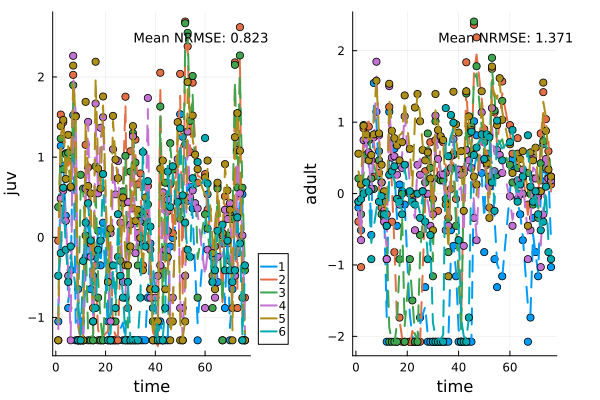

In [80]:
plot_state_estimates(model_2)

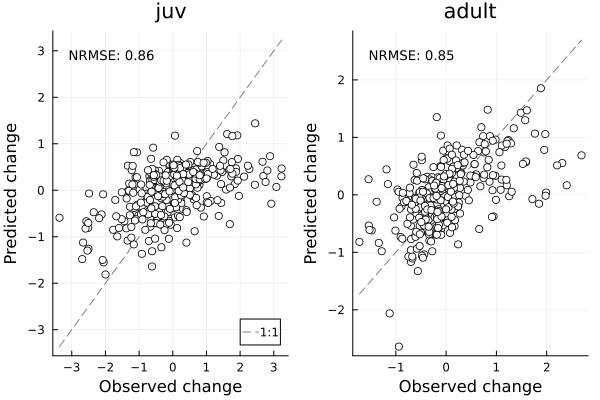

In [81]:
plot_predictions(model_2)

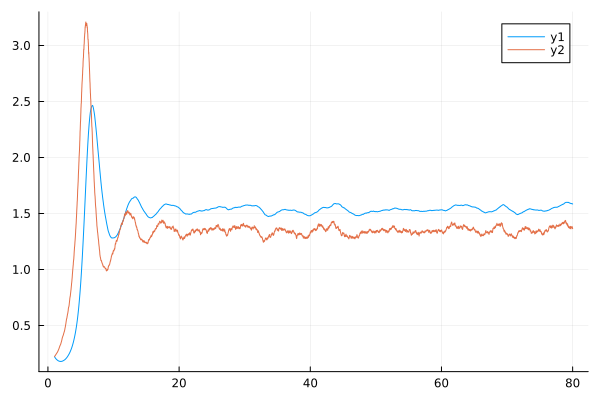

In [83]:
using Distributions
site = 4
with_noise = true
sigma = 0.25
pyc = -2.0

rhs = u -> model_2.process_model.right_hand_side(u,site,[pyc,0.0],model_2.parameters.process_model, 0)
u = [-1.5,-1.5]
dt = 0.01
kelp = []
j_kelp = []
ts = 1:dt:80
for i in ts
    u = u .+ dt*rhs(u)
    if with_noise 
        u =  u .+ dt .* sigma.* [1,0.1] .* rand(Normal(0,1),2)
    end 
    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(ts,exp.(kelp))
Plots.plot!(ts,exp.(j_kelp))

# Rugosity effects on dynamics 

for this last case I use site level measures of sea floor rugosity to explain differnce in the dynamcis betwen sites.  

In [132]:
NN, NNparameters = SimpleNeuralNetwork(2+2,2, hidden = 5)
function derivs_3!(du,u,i,X,p,t)
    inputs = vcat(u,X[1:2])
    du .=  NN(inputs,p.NN)
end

init_parameters = (NN = NNparameters, )

model_3 = MultiCustomDerivatives(training,X,derivs_3!,init_parameters;
                        proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                         time_column_name = "time", series_column_name = "series" )
nothing

In [133]:
gradient_descent!(model_3, verbose = true, maxiter = 250, step_size = 0.05)
gradient_descent!(model_3, verbose = true, maxiter = 250, step_size = 0.025)

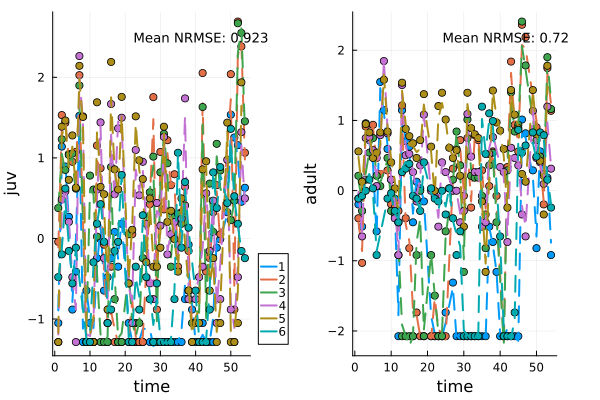

In [136]:
plot_state_estimates(model_3)

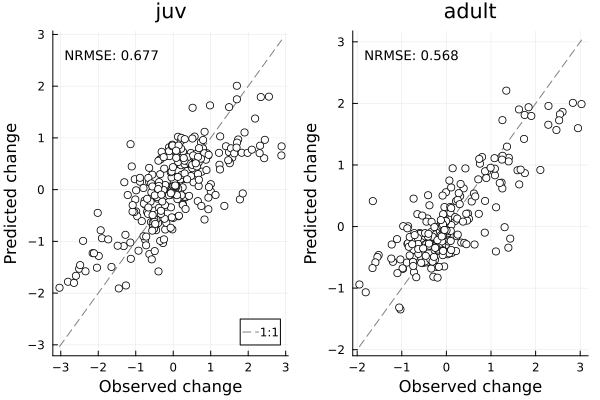

In [137]:
plot_predictions(model_3)

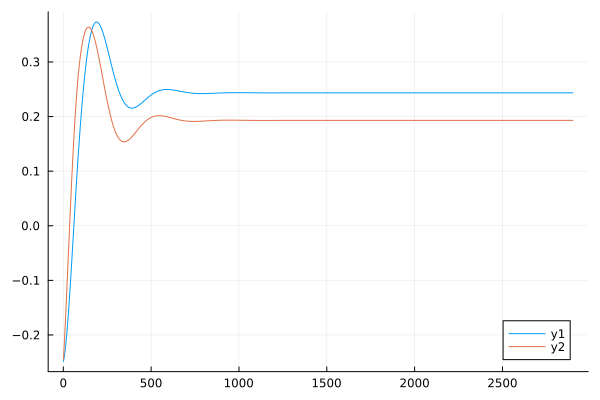

In [219]:
site = 1
pyc = 1.0
rug = 1.0
with_noise = false
sigma = 0.5
u = [-0.25,-0.25]

rhs = u -> model_3.process_model.right_hand_side(u,site,[0.0,0.0,pyc,rug],model_3.parameters.process_model, 0)

dt = 0.01
kelp = []
j_kelp = []
for i in 1:dt:30
    u = u .+ dt*rhs(u)
    if with_noise 
        u =  u .+ dt .*  [sigma,0.0] .* rand(Normal(0,1),2)
    end 
    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(kelp)
Plots.plot!(j_kelp)

# kelp UDE model

$$
\frac{dJ}{dt} = J*NN_J(J,A) - gJ - J*NN_m(A,P(t),X_i)\\
\frac{dA}{dt} = gJ - A*NN_m(A,P(t),X_i)
$$

In [245]:
dat_UDE = CSV.read("../data/processed_time_series_no_log.csv", DataFrame)[:,2:end]
rename!(dat_UDE, ["time","series","juv","adult"])
training_UDE = dat_UDE[dat_UDE.time .< 55,:]
testing_UDE = dat_UDE[dat_UDE.time .>= 55,:]
training_UDE[1:4,:]

4×4 DataFrame
 Row │ time   series  juv        adult    
     │ Int64  Int64   Float64    Float64  
─────┼────────────────────────────────────
   1 │     1       1  0.0121877  0.42306
   2 │     1       2  0.182815   0.323517
   3 │     1       3  0.402193   0.721691
   4 │     1       4  0.0        0.472832

In [329]:


NNm, NNparameters_m = SimpleNeuralNetwork(2,2, hidden = 5)

function derivs_4!(du,u,i,X,p,t)
    mortality = NNm(vcat(u[2:2],X[1:1]),p.NNm)
    du1 = abs(p.r)*u[2] - abs(p.g)*u[1] - u[1]*abs(mortality[1])
    du2 = abs(p.g)*u[1] - u[2]*abs(mortality[2]) 
    du .= [du1,du2]
end

init_parameters = (NNm = NNparameters_m, g =0.15, r = 1.0)

model_4 = MultiCustomDerivatives(training_UDE,X,derivs_4!,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")
                
model_4.loss_function(model_4.parameters)

10.786480328235392

In [330]:
gradient_descent!(model_4, verbose = true, maxiter = 100, step_size = 0.05)


In [331]:
gradient_descent!(model_4, verbose = true, maxiter = 250, step_size = 0.025)

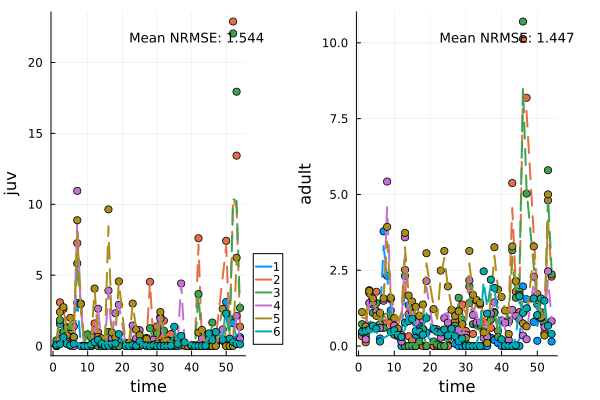

In [332]:
plot_state_estimates(model_4)

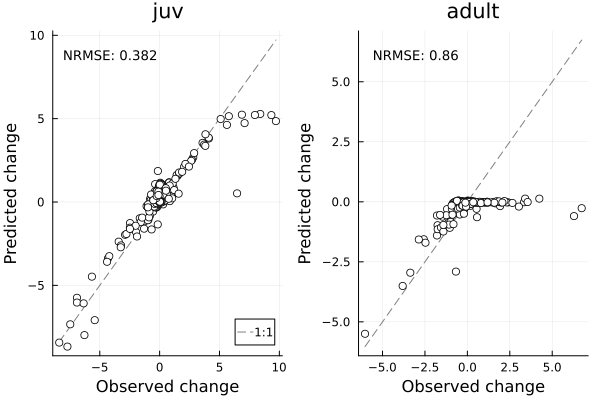

In [333]:
plot_predictions(model_4)

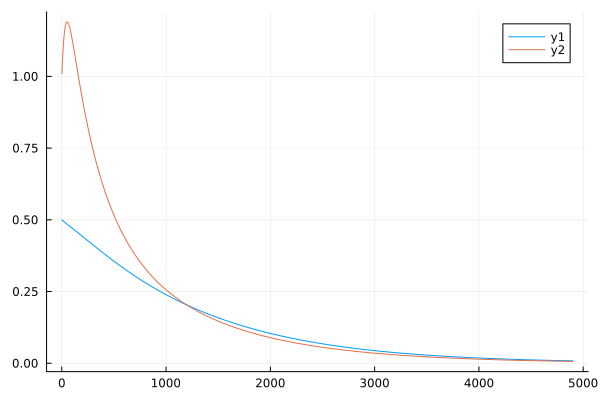

In [338]:
site = 1
pyc = 0.0
rug = 0.0
with_noise = false
sigma = 0.5
u = [1.0,0.5]

rhs = u -> model_4.process_model.right_hand_side(u,site,[pyc,rug],model_4.parameters.process_model, 0)

dt = 0.01
kelp = []
j_kelp = []
for i in 1:dt:50
    u = u .+ dt*rhs(u)
    if with_noise 
        u =  u .+ dt .*  [sigma,0.0] .* rand(Normal(0,1),2)
    end 
    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(kelp)
Plots.plot!(j_kelp)